In [39]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import math
# import dgl
# from dgl.nn import GATConv
from time import time
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder

from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt

from google.colab import drive

In [40]:
sns.set_style("whitegrid")

### Model

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0), :]
        return self.dropout(x)

In [42]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None, is_causal=True):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

In [43]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(
            self,
            tgt,
            memory,
            tgt_mask=None,
            memory_mask=None,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=None,
            tgt_is_causal=True,
            memory_is_causal=True
        ):
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

In [44]:
class TranAD(nn.Module):
    def __init__(self, feats, lr, batch_size, window_size):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = lr
        self.batch = batch_size
        self.n_feats = feats
        self.n_window = window_size
        self.n = self.n_feats * self.n_window
        self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
        encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 1)
        decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
        decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
        self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())
        self.double()

    def encode(self, src, c, tgt):
        src = torch.cat((src, c), dim=2)
        src = src * math.sqrt(self.n_feats)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        tgt = tgt.repeat(1, 1, 2)
        return tgt, memory

    def forward(self, src, tgt):
        # Phase 1 - Without anomaly scores
        c = torch.zeros_like(src)
        x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
        # Phase 2 - With anomaly scores
        c = (x1 - src) ** 2
        x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        return x1, x2

### Data

In [45]:
# Set directory
BASE_DIR = Path(f"/content/drive/MyDrive/RedHack")

drive.mount('/content/drive')
DATA_DIR = BASE_DIR.joinpath("data")

FILE_RESP = "web_response.csv"
FILE_THR = "throughput.csv"
FILE_ERROR = "error.csv"
FILE_APDEX = "apdex.csv"

RESP_DATA = DATA_DIR.joinpath(FILE_RESP)
THR_DATA = DATA_DIR.joinpath(FILE_THR)
ERROR_DATA = DATA_DIR.joinpath(FILE_ERROR)
APDEX_DATA = DATA_DIR.joinpath(FILE_APDEX)

web_response = pd.read_csv(RESP_DATA, header=0, sep=',', index_col=0)
throughput = pd.read_csv(THR_DATA, header=0, sep=',', index_col=0)
error = pd.read_csv(ERROR_DATA, header=0, sep=',', index_col=0)
apdex = pd.read_csv(APDEX_DATA, header=0, sep=',', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
print(f"web_response: {web_response.shape}")
print(f"throughput: {throughput.shape}")
print(f"error: {error.shape}")
print(f"apdex: {apdex.shape}")

web_response: (43272, 2)
throughput: (43272, 2)
error: (43272, 2)
apdex: (43272, 2)


In [47]:
web_response.rename(columns={"point": "timestamp"}, inplace=True)
throughput.rename(columns={"point": "timestamp", "sum_call_count": "throughput"}, inplace=True)
error.rename(columns={"point": "timestamp", "ratio": "error"}, inplace=True)
apdex.rename(columns={"time": "timestamp", " ": "apdex"}, inplace=True)

In [86]:
# Multivariate task
# Concat all data

ts_df = pd.merge(web_response, throughput, on="timestamp")
ts_df = pd.merge(ts_df, error, on="timestamp")
ts_df = pd.merge(ts_df, apdex, on="timestamp")

timestamp = ts_df["timestamp"]
ts_df.drop("timestamp", inplace=True, axis=1)

In [52]:
# Remove seasonality

# from statsmodels.tsa.seasonal import seasonal_decompose

# result = seasonal_decompose(ts_df['web_response'], model='additive', period=1440)  # Period is the number of minutes in a day
# ts_df['web_response'] = ts_df['web_response'] - result.seasonal

# result = seasonal_decompose(ts_df['throughput'], model='additive', period=1440)  # Period is the number of minutes in a day
# ts_df['throughput'] = ts_df['throughput'] - result.seasonal

# result = seasonal_decompose(ts_df['error'], model='additive', period=1440)  # Period is the number of minutes in a day
# ts_df['error'] = ts_df['error'] - result.seasonal

# result = seasonal_decompose(ts_df['apdex'], model='additive', period=1440)  # Period is the number of minutes in a day
# ts_df['apdex'] = ts_df['apdex'] - result.seasonal

In [53]:
ts_df.shape

(43272, 4)

In [87]:
def min_max_scaling(df, phi=0.05):
    df_normalized = df.copy()
    for column in df.columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df_normalized[column] = (df[column] - min_val) / (max_val - min_val + phi)
    return df_normalized

In [88]:
def plot_columns(df):
    num_cols = df.shape[1]
    fig, axes = plt.subplots(num_cols, 1, figsize=(15, 5*num_cols))

    for i, column in enumerate(df.columns):
        ax = axes[i] if num_cols > 1 else axes
        ax.plot(df[column])
        ax.set_title(column)

    plt.tight_layout()
    plt.show()

In [14]:
# Data Prepocessing
# X_train, X_test = ts_df[:int(ts_df.shape[0]*0.7)], ts_df[int(ts_df.shape[0]*0.7):]

# X_train_norm = min_max_scaling(X_train, phi=0.0)
# X_test_norm = min_max_scaling(X_test, phi=0.0)

# X_train_norm = [normalize(val, X_train["web_response"].min(), X_train["web_response"].max()) for val in X_train["web_response"]]
# X_test_norm = [normalize(val, X_test["web_response"].min(), X_test["web_response"].max()) for val in X_test["web_response"]]

In [89]:
X_train_norm = min_max_scaling(ts_df, phi=0.0)

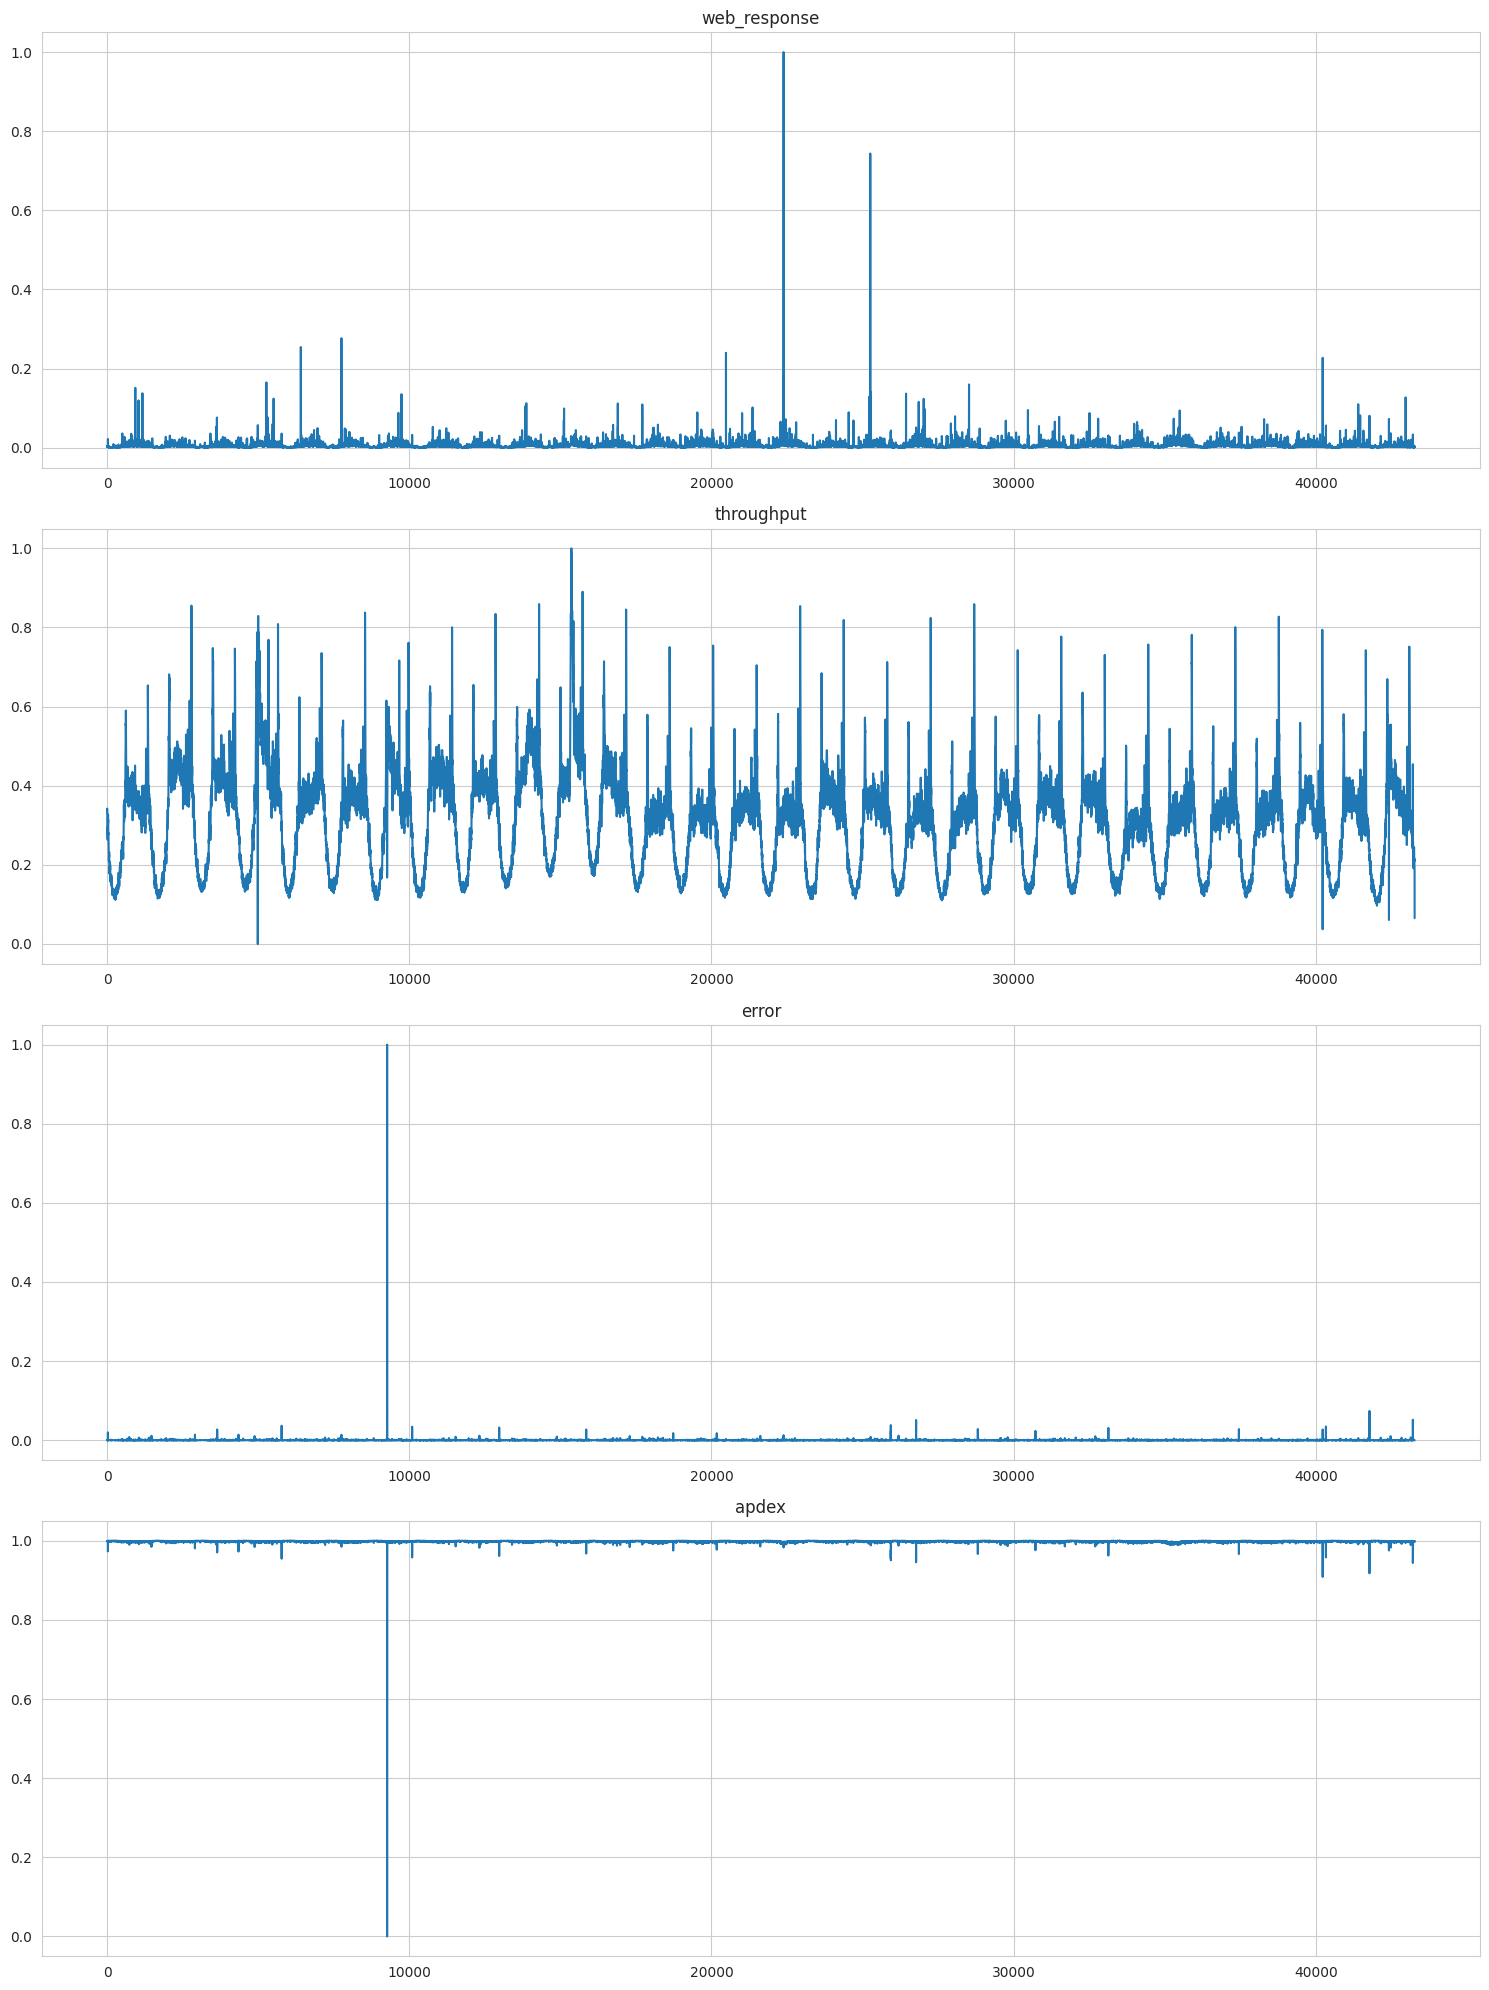

In [90]:
plot_columns(X_train_norm)

In [91]:
X_train_norm.columns = [i for i in range(X_train_norm.shape[1])]
# X_test_norm.columns = [i for i in range(X_test_norm.shape[1])]

In [92]:
train_loader = DataLoader(np.array(X_train_norm), batch_size=len(X_train_norm))
# test_loader = DataLoader(np.array(X_test_norm), batch_size=len(X_test_norm))

### Train

In [93]:
class color:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    RED = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [94]:
def convert_to_windows(data, model):
    windows = []
    w_size = model.n_window
    for i, g in enumerate(data):
        if i >= w_size:
            w = data[i-w_size:i]
        else:
            w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
        windows.append(w)
    return torch.stack(windows)

In [95]:
def backprop(epoch, model, data, dataO, optimizer, scheduler, training = True):
    # l = nn.MSELoss(reduction = 'mean' if training else 'none')
    feats = dataO.shape[1]
    l = nn.MSELoss(reduction = 'none')
    data_x = torch.DoubleTensor(data)
    dataset = TensorDataset(data_x, data_x)
    bs = model.batch if training else len(data)
    dataloader = DataLoader(dataset, batch_size=bs)
    n = epoch + 1; w_size = model.n_window
    l1s, l2s = [], []
    if training:
        for d, _ in dataloader:
            local_bs = d.shape[0]
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, local_bs, feats)
            z = model(window, elem)
            l1 = l(z, elem) if not isinstance(z, tuple) else (1 / n) * l(z[0], elem) + (1 - 1/n) * l(z[1], elem)
            if isinstance(z, tuple):
                z = z[1]
            l1s.append(torch.mean(l1).item())
            loss = torch.mean(l1)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        scheduler.step()
        tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s)}')
        return np.mean(l1s), optimizer.param_groups[0]['lr']
    else:
        for d, _ in dataloader:
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, bs, feats)
            z = model(window, elem)
            if isinstance(z, tuple):
                z = z[1]
        loss = l(z, elem)[0]
        return loss.detach().numpy(), z.detach().numpy()[0]

In [96]:
def save_model(model, optimizer, scheduler, epoch, accuracy_list, num_exp):
	folder = f'{BASE_DIR}/checkpoints/TranAD_TS/Experiment_{num_exp}'
	os.makedirs(folder, exist_ok=True)
	file_path = f'{folder}/model.ckpt'
	torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'accuracy_list': accuracy_list}, file_path)

In [97]:
def plot_accuracies(accuracy_list, folder, num_exp):
	os.makedirs(f'{BASE_DIR}/plots/{folder}/Experiment_{num_exp}', exist_ok=True)
	trainAcc = [i[0] for i in accuracy_list]
	lrs = [i[1] for i in accuracy_list]
	plt.xlabel('Epochs')
	plt.ylabel('Average Training Loss')
	plt.plot(range(len(trainAcc)), trainAcc, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
	plt.twinx()
	plt.plot(range(len(lrs)), lrs, label='Learning Rate', color='r', linewidth=1, linestyle='--', marker='.')
	plt.savefig(f'{BASE_DIR}/plots/{folder}/Experiment_{num_exp}/training-graph.pdf')
	plt.clf()

In [98]:
def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [99]:
def plotter(name, y_true, y_pred, ascore, labels, num_exp):
    y_true = torch.roll(y_true, 1, 0)
    os.makedirs(os.path.join(f'plots/', f'{name}/Experiment_{num_exp}'), exist_ok=True)
    pdf = PdfPages(f'{BASE_DIR}/plots/{name}/Experiment_{num_exp}/output.pdf')
    for dim in range(y_true.shape[1]):
        y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[dim], ascore[:, dim]
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Value')
        ax1.set_title(f'Dimension = {dim}')
        # if dim == 0: np.save(f'true{dim}.npy', y_t); np.save(f'pred{dim}.npy', y_p); np.save(f'ascore{dim}.npy', a_s)
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
        ax3 = ax1.twinx()
        ax3.plot(l, '--', linewidth=0.3, alpha=0.5)
        ax3.fill_between(np.arange(len(l)), l, color='blue', alpha=0.3)
        if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        ax2.plot(smooth(a_s), linewidth=0.2, color='g')
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Anomaly Score')
        pdf.savefig(fig)
        plt.close()
    pdf.close()

In [105]:
# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_LABELS = X_train_norm.shape[1]
LEARNING_RATE = 10e-5
WINDOW_SIZE = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [106]:
model = TranAD(
    feats=NUM_LABELS,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    window_size=WINDOW_SIZE
)
optimizer = torch.optim.AdamW(model.parameters(), lr=model.lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

In [76]:
# Prepare data
# trainD, testD = next(iter(train_loader)), next(iter(test_loader))
# trainO, testO = trainD, testD

# trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)

In [107]:
trainD = next(iter(train_loader))
trainO = trainD

trainD = convert_to_windows(trainD, model)

In [108]:
NUM_EXP = 2
accuracy_list = []
start = time()
for e in tqdm(list(range(NUM_EPOCHS))):
	lossT, lr = backprop(e, model, trainD, trainO, optimizer, scheduler)
	accuracy_list.append((lossT, lr))

print(color.BOLD+'Training time: '+"{:10.4f}".format(time()- start)+' s'+color.ENDC)
save_model(model, optimizer, scheduler, e, accuracy_list, num_exp=NUM_EXP)
plot_accuracies(accuracy_list, f'TranAD_TS', num_exp=NUM_EXP)
# Save params
params_dict = {
	   "batch_size": int(BATCH_SIZE),
	   "epochs": int(NUM_EPOCHS),
	   "labels": list(ts_df.columns),
	   "lr": int(LEARNING_RATE),
	   "window_size": int(WINDOW_SIZE)
}


import json
os.makedirs(f'plots/TranAD/Experiment_{NUM_EXP}', exist_ok=True)
with open(f'{BASE_DIR}/plots/TranAD_TS/Experiment_{NUM_EXP}/params.json', 'w', encoding='utf-8') as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)

  5%|▌         | 1/20 [00:13<04:09, 13.15s/it]

Epoch 0,	L1 = 0.10874146895675808


 10%|█         | 2/20 [00:25<03:52, 12.90s/it]

Epoch 1,	L1 = 0.02217514140035156


 15%|█▌        | 3/20 [00:38<03:38, 12.84s/it]

Epoch 2,	L1 = 0.009302414142203274


 20%|██        | 4/20 [00:51<03:26, 12.88s/it]

Epoch 3,	L1 = 0.007158307521003331


 25%|██▌       | 5/20 [01:05<03:16, 13.07s/it]

Epoch 4,	L1 = 0.005646260236367767


 30%|███       | 6/20 [01:18<03:04, 13.15s/it]

Epoch 5,	L1 = 0.004617450175969515


 35%|███▌      | 7/20 [01:31<02:50, 13.12s/it]

Epoch 6,	L1 = 0.003917713805898506


 40%|████      | 8/20 [01:44<02:37, 13.12s/it]

Epoch 7,	L1 = 0.003228023284695017


 45%|████▌     | 9/20 [01:58<02:25, 13.26s/it]

Epoch 8,	L1 = 0.0025636305053745832


 50%|█████     | 10/20 [02:11<02:13, 13.38s/it]

Epoch 9,	L1 = 0.002009409965649968


 55%|█████▌    | 11/20 [02:25<02:01, 13.45s/it]

Epoch 10,	L1 = 0.0016200105236146493


 60%|██████    | 12/20 [02:38<01:47, 13.44s/it]

Epoch 11,	L1 = 0.0013619505113440687


 65%|██████▌   | 13/20 [02:52<01:34, 13.46s/it]

Epoch 12,	L1 = 0.001158190810394305


 70%|███████   | 14/20 [03:05<01:20, 13.41s/it]

Epoch 13,	L1 = 0.001021062062205941


 75%|███████▌  | 15/20 [03:19<01:07, 13.57s/it]

Epoch 14,	L1 = 0.0009002777583414424


 80%|████████  | 16/20 [03:32<00:53, 13.50s/it]

Epoch 15,	L1 = 0.0007971422529133966


 85%|████████▌ | 17/20 [03:45<00:40, 13.40s/it]

Epoch 16,	L1 = 0.0007136979106419687


 90%|█████████ | 18/20 [03:59<00:26, 13.35s/it]

Epoch 17,	L1 = 0.000641786748425164


 95%|█████████▌| 19/20 [04:12<00:13, 13.28s/it]

Epoch 18,	L1 = 0.0005699891766606574


100%|██████████| 20/20 [04:25<00:00, 13.30s/it]


Epoch 19,	L1 = 0.0005244940388379642
Training time:   265.9903 s


<Figure size 640x480 with 0 Axes>

### Test

In [127]:
torch.zero_grad = True
model.eval()
print(f'{color.HEADER}Testing TranAD on TS{color.ENDC}')
# loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
loss, y_pred = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)

# testO = torch.roll(testO, 1, 0)
trainO = torch.roll(trainO, 1, 0)
# plotter(f'TranAD_TS', testO, y_pred, loss, X_test.columns)
plotter(f'TranAD_TS', trainO, y_pred, loss, ts_df.columns, num_exp=NUM_EXP)

Testing TranAD on TS


<Axes: >

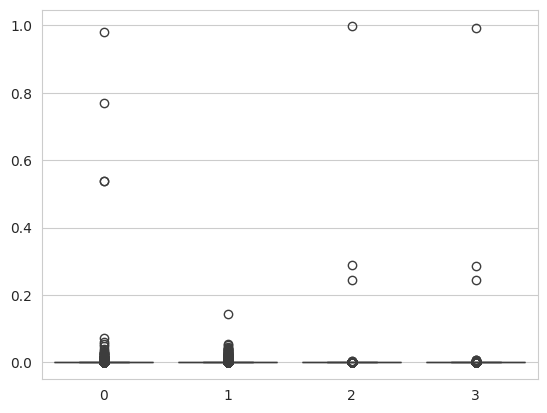

In [128]:
sns.boxplot(loss)

In [118]:
q90 = np.quantile(loss, q=0.9)
sum(loss >= q90)

array([ 1178, 15949,    41,   141])

In [122]:
def detect_anomalies( q, anomaly_score, labels):
    # False - norm
    # True - outlier
    q_n = np.quantile(anomaly_score, q=q)
    anomaly_arr = anomaly_score >= q_n
    return anomaly_arr

In [125]:
anomaly_arr = detect_anomalies(q=0.9, anomaly_score=loss, labels=ts_df.columns)

In [133]:
test_data = trainO.cpu().detach().numpy()

In [ ]:
test_df = pd.DataFrame()

In [115]:
# On short win
